---
title: "Lab 7 - Heart Attack"
author: "Tyler Allen"
date: "2024-11-25"
format:
  html:
    cold-fold: true
    embed-resources: true
theme: "lux"
---

In [2]:
import pandas as pd
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [ ]:
#input this at the end to get rid of the unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

**Part One: Fitting Models**

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

  - Find the best model based on ROC AUC for predicting the target variable.

  - Report the (cross-validated!) ROC AUC metric.

  - Fit the final model.

  - Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

  - (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

**Q1: KNN**

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

X = ha.drop(columns=['output'])
y = ha['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
#define KNN model
knn = KNeighborsClassifier()

#hyperparameter grid
param_grid = {'n_neighbors': range(1, 31)}

#GridSearch with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

#best parameters and ROC AUC score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best number of neighbors: {best_k}")
print(f"Best cross-validated ROC AUC score: {best_score}")

Best number of neighbors: 13
Best cross-validated ROC AUC score: 0.8723201345755693


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [5]:
#fitting final model with best k
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

#predicting on the test set
y_pred = final_knn.predict(X_test_scaled)
y_pred_proba = final_knn.predict_proba(X_test_scaled)[:, 1]

#roc auc
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc}")

Test ROC AUC: 0.6803713527851459


In [7]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[13 13]
 [10 19]]


**Q2: Logistic Regression**

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#data is loaded, data is split and standardized

#defining logistic regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)

#pipeline with hyperparameter tuning
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2']  #L1 and L2 regularization
}

#GridSearchCV with the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(solver='liblinear', random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', refit=True)
grid_search.fit(X_train, y_train)

#best parameters and ROC AUC
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated ROC AUC: {grid_search.best_score_}")
print(f"Best regularization parameter C: {best_C}")

Best parameters: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2'}
Best cross-validated ROC AUC: 0.8645005175983437
Best regularization parameter C: 0.01


In [27]:
#fitting the final model
final_model = grid_search.best_estimator_

#training model on training set
final_model.fit(X_train, y_train)

#predicting on test set
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

#roc auc
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc}")

Test ROC AUC: 0.7957559681697612


In [28]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[18  8]
 [ 7 22]]


With this model we have 18 TNs, 8 FPs, 7 FNs, and 22 TPs. This gives us an accuracy score of 72.72%.

In [48]:
#extracting coefficients and feature names
coefficients = final_model.named_steps['log_reg'].coef_[0]
features = X.columns

#combining features and coefficients for interpretation
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("Feature Coefficients:")
print(coef_df)

Feature Coefficients:
   Feature  Coefficient
6  thalach     0.281803
2       cp     0.249859
5  restecg     0.094277
4     chol    -0.023176
3   trtbps    -0.061657
0      age    -0.129045
1      sex    -0.220666


With a coefficient of 0.2818, this means that a 1 unit increase in thalach increases the log-odds of heart disease by 0.2818. With the following positive coefficients, these variables are all positively correlated with being at risk for heart disease, and the variables with negative coefficients are negatively correlated with being at risk for heart disease.

Age has an interesting coefficient here, since heart disease risk usually increases with age. This could mean that there are interactions that could affect this model here.

**Q3: Decision Tree**

In [42]:
from sklearn.tree import DecisionTreeClassifier

#defining decision tree model
dt = DecisionTreeClassifier(random_state=42)

#defining hyperparameter grid
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [5, 10, 20],  #min samples in a leaf
    'max_leaf_nodes': [5, 10, 20],  #max number of leaf nodes
    'ccp_alpha': [0.0, 0.01, 0.1]  #cost complexity pruning
}

#GridSearch with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', refit=True)
grid_search.fit(X_train, y_train)

#best parameters and ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated ROC AUC score: {best_score}")

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 4, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best cross-validated ROC AUC score: 0.8109006211180125


In [43]:
#fiting final decision tree model
final_dt = grid_search.best_estimator_
final_dt.fit(X_train, y_train)

#predict on test set
y_pred = final_dt.predict(X_test)
y_pred_proba = final_dt.predict_proba(X_test)[:, 1]

#evaluating model
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc}")

Test ROC AUC: 0.7009283819628647


In [44]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[19  7]
 [10 19]]


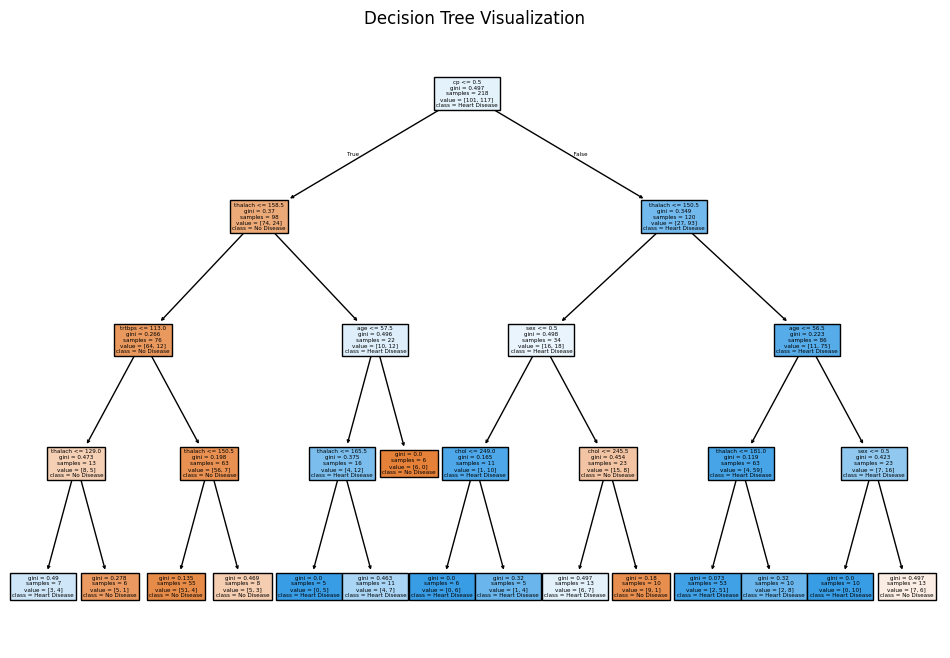

In [45]:
#visualization
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
tree.plot_tree(final_dt, feature_names=X.columns, class_names=['No Disease', 'Heart Disease'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [50]:
#feature importance (consulted ChatGPT with this)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
   Feature  Importance
2       cp    0.476051
6  thalach    0.228228
1      sex    0.125079
0      age    0.107777
4     chol    0.037550
3   trtbps    0.025315
5  restecg    0.000000


The variables cp, thalach, sex, and age were the variables that were the most important in this decision tree. Chol, trtbps, and restecg were not as important in this model.

**Q4: Interpretation**

Which predictors were most important to predicting heart attack risk?

Across the different models, the predictors that were most important to predicting heart attack risk were maximum heart rate achieved during exercise (thalach), chest pain type (cp), and resting electrocardiographic results (restecg). In the logistic regression and decision tree models, these three were most postiively associated with heart disease risk and were also the most important factors in the decison tree.

**Q5: ROC Curve**

Plot the ROC Curve for your three models above.

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#probabilities for KNN
y_pred_proba_knn = final_knn.predict_proba(X_test_scaled)[:, 1]

#FP rate, TP rate, and AUC for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

In [52]:
#probabilities for logistic regression
y_pred_proba_log_reg = final_log_reg.predict_proba(X_test_scaled)[:, 1]

#FP rate, TP rate, and AUC for Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_proba_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

In [53]:
#probabilities for decision tree
y_pred_proba_dt = final_dt.predict_proba(X_test)[:, 1]

#FP rate, TP rate, and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

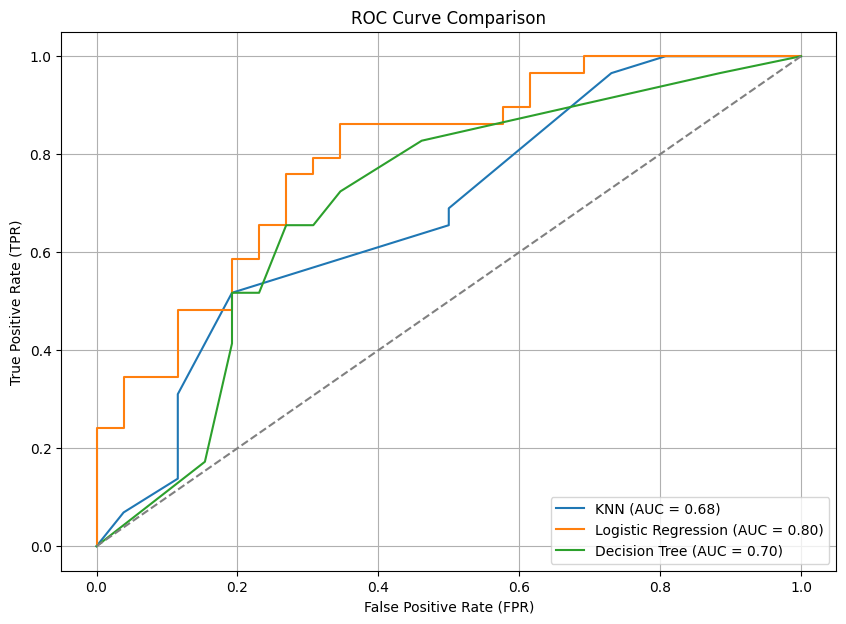

In [54]:
plt.figure(figsize=(10, 7))

#ROC for KNN
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

#ROC for logistic regression
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

#ROC for decision tree
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

#diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

#labels and legend
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Part Two: Metrics**

Consider the following metrics:

  - True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

  - Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

  - True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [60]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer
import numpy as np

#used ChatGPT here because I got a ton of warnings when I did it the original way
def specificity_score(y_true, y_pred):
    #confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity_score)

In [61]:
#cross-validated recall
recall_knn = cross_val_score(final_knn, X_train_scaled, y_train, cv=5, scoring='recall')

#cross-validated precision
precision_knn = cross_val_score(final_knn, X_train_scaled, y_train, cv=5, scoring='precision')

specificity_knn = cross_val_score(final_knn, X_train_scaled, y_train, cv=5, scoring=specificity_scorer)

print(f"KNN Metrics:")
print(f"Recall (Sensitivity): {np.mean(recall_knn):.2f}")
print(f"Precision: {np.mean(precision_knn):.2f}")
print(f"Specificity for KNN: {np.mean(specificity_knn):.2f}")

KNN Metrics:
Recall (Sensitivity): 0.89
Precision: 0.77
Specificity for KNN: 0.69


In [63]:
#cross-validated recall
recall_log_reg = cross_val_score(final_log_reg, X_train_scaled, y_train, cv=5, scoring='recall')

#cross-validated precision
precision_log_reg = cross_val_score(final_log_reg, X_train_scaled, y_train, cv=5, scoring='precision')

#cross-validated specificity
specificity_log_reg = cross_val_score(final_log_reg, X_train_scaled, y_train, cv=5, scoring=specificity_scorer)

print(f"Logistic Regression Metrics:")
print(f"Recall (Sensitivity): {np.mean(recall_log_reg):.2f}")
print(f"Precision: {np.mean(precision_log_reg):.2f}")
print(f"Specificity: {np.mean(specificity_log_reg):.2f}")

Logistic Regression Metrics:
Recall (Sensitivity): 0.84
Precision: 0.80
Specificity: 0.76


In [65]:
#cross-validated recall
recall_dt = cross_val_score(final_dt, X_train, y_train, cv=5, scoring='recall')

#cross-validated precision
precision_dt = cross_val_score(final_dt, X_train, y_train, cv=5, scoring='precision')

#cross-validated specificity
specificity_dt = cross_val_score(final_dt, X_train, y_train, cv=5, scoring=specificity_scorer)

print(f"Decision Tree Metrics:")
print(f"Recall (Sensitivity): {np.mean(recall_dt):.2f}")
print(f"Precision: {np.mean(precision_dt):.2f}")
print(f"Specificity: {np.mean(specificity_dt):.2f}")

Decision Tree Metrics:
Recall (Sensitivity): 0.75
Precision: 0.78
Specificity: 0.74


**Part Three: Discussion**

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

  - Which metric(s) you would use for model selection and why.

  - Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

  - What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

**Q1**

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In this scenario, the hospital needs to focus on minimizing the amount of false negatives to avoid the lawsuits, which means they incorrectly identify patients as low risk who later have a heart attack. So, I would use both precision and recall because in this case the proportion of actual high-risk patients becing correctly identified is just as important as the proportion of positive predictions that are correct. If I had to choose one, I would choose recall.

Of my three models , I would choose the logistic regression model to recommend to the hospital because it had the highst values of precision and specificity and the second highest value of recall.

I would expect a recall score of 84 when predicting future observations, which is the cross-validated recall score I got in Part 2.


**Q2**

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

In this scenario, the hospital needs to focus on accurately identifying patients who truly need monitoring while minimizing the ones they incorrectly label as in need of monitoring. So, I would focus on precision and recall, but if I had to choose one, I'd probably choose to use precision because it would ensure that the hospital uses its bed space efficiently as possible.

I would recommend the logistic regression model to the hospital because it has the highest precision score.

I would expect a recall score of 80 when predicting future observations, which is the cross-validated precision score I got in Part 2.

**Q3**

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

In this scenario, the hospital wants to know which factors are associated with heart attack risk, so the coefficients from the logistic regression coefficients would be the most useful metrics here.

With that being said, the logistic regression model would be the most useful here because it shows how each variable is associated with heart attack risk.

I would expect the follwoing variables to have similar correlations to heart attack as the coeffecients that follow:  

1. thalach     0.281803
2. cp     0.249859
3. restecg     0.094277
4. chol    -0.023176
5. trtbps    -0.061657
6. age    -0.129045
7. sex    -0.220666

**Q4**

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

In this scenario, the hospital wants to evaluate the doctors' diagnoses accuracy with the algorithm's predictions, so I would choose to look at a model accuracy metric, such as an F1 score. Since I didn't compute that, I would choose recall because recall in this case reflects the doctors' ability to identify high-risk patients effectively and because missing high-risk patients is probably more dangerous than overpredicting high-risk patients in a hospital.

Since the KNN model had the highest recall score, I would choose that model to recommend to the hospital.

I would expect a recall score of .89 which is the cross-validated recall score I got in Part 2.

**Part Four: Validation**

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [67]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [69]:
X_validation = ha_validation.drop(columns=['output'])
y_validation = ha_validation['output']

#standardizing
X_validation_scaled = scaler.transform(X_validation)  #reusing scaler from part 1

In [70]:
#KNN
y_pred_knn = final_knn.predict(X_validation_scaled)
y_pred_proba_knn = final_knn.predict_proba(X_validation_scaled)[:, 1]

#confusion matrix
conf_matrix_knn = confusion_matrix(y_validation, y_pred_knn)
print("KNN Confusion Matrix:")
print(conf_matrix_knn)

#metrics
roc_auc_knn = roc_auc_score(y_validation, y_pred_proba_knn)
precision_knn = precision_score(y_validation, y_pred_knn)
recall_knn = recall_score(y_validation, y_pred_knn)

print(f"KNN Validation Metrics:")
print(f"ROC AUC: {roc_auc_knn:.2f}")
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")

KNN Confusion Matrix:
[[ 9  2]
 [ 5 14]]
KNN Validation Metrics:
ROC AUC: 0.94
Precision: 0.88
Recall: 0.74


In [71]:
#logistic regression
y_pred_log_reg = final_log_reg.predict(X_validation_scaled)
y_pred_proba_log_reg = final_log_reg.predict_proba(X_validation_scaled)[:, 1]

#confusion matrix
conf_matrix_log_reg = confusion_matrix(y_validation, y_pred_log_reg)
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_log_reg)

#metrics
roc_auc_log_reg = roc_auc_score(y_validation, y_pred_proba_log_reg)
precision_log_reg = precision_score(y_validation, y_pred_log_reg)
recall_log_reg = recall_score(y_validation, y_pred_log_reg)

print(f"Logistic Regression Validation Metrics:")
print(f"ROC AUC: {roc_auc_log_reg:.2f}")
print(f"Precision: {precision_log_reg:.2f}")
print(f"Recall: {recall_log_reg:.2f}")

Logistic Regression Confusion Matrix:
[[10  1]
 [ 4 15]]
Logistic Regression Validation Metrics:
ROC AUC: 0.92
Precision: 0.94
Recall: 0.79


In [72]:
#decision tree
y_pred_dt = final_dt.predict(X_validation)
y_pred_proba_dt = final_dt.predict_proba(X_validation)[:, 1]

#confusion matrix
conf_matrix_dt = confusion_matrix(y_validation, y_pred_dt)
print("Decision Tree Confusion Matrix:")
print(conf_matrix_dt)

#metrics
roc_auc_dt = roc_auc_score(y_validation, y_pred_proba_dt)
precision_dt = precision_score(y_validation, y_pred_dt)
recall_dt = recall_score(y_validation, y_pred_dt)

print(f"Decision Tree Validation Metrics:")
print(f"ROC AUC: {roc_auc_dt:.2f}")
print(f"Precision: {precision_dt:.2f}")
print(f"Recall: {recall_dt:.2f}")

Decision Tree Confusion Matrix:
[[ 9  2]
 [ 5 14]]
Decision Tree Validation Metrics:
ROC AUC: 0.85
Precision: 0.88
Recall: 0.74


I would say that the measures of model success from cross-validation were approximately correct for the validation data. The ROC AUC values were higher, precision improved significantly, and recall was slightly lower, but overall it did well.

**Part Five: Cohen’s Kappa**

Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

https://datatab.net/tutorial/cohens-kappa

In [73]:
from sklearn.metrics import cohen_kappa_score

# KNN
kappa_knn = cohen_kappa_score(y_test, final_knn.predict(X_test_scaled))
print(f"KNN Cohen's Kappa: {kappa_knn:.2f}")

# Logistic Regression
kappa_log_reg = cohen_kappa_score(y_test, final_log_reg.predict(X_test_scaled))
print(f"Logistic Regression Cohen's Kappa: {kappa_log_reg:.2f}")

# Decision Tree
kappa_dt = cohen_kappa_score(y_test, final_dt.predict(X_test))
print(f"Decision Tree Cohen's Kappa: {kappa_dt:.2f}")

KNN Cohen's Kappa: 0.16
Logistic Regression Cohen's Kappa: 0.45
Decision Tree Cohen's Kappa: 0.38


Cohen's Kappa evaluates overall agreement and considers both positive and negative cases, unlike other metrics such as accurary which can be inflated in ways. Cohen's Kappa is useful in situations where decisions are subjective and and the categories are nominal, such as assessments of two doctors on a patient. The logistic regression model has the best Cohen's Kappa (.45) which indicates that there is better agreement with true labels compared to the KNN and Decision Tree models, so that conclusion does not change. Also, the KNN model had the worst Cohen's Kappa of 0.16, suggesting that it lacks robustness (for lack of a better word). I believe this makes sense because Cohen's Kappa tends to highlight the generalization abilities of models across both classes which is why KNN had the lowest score and logistic regression had the highest.


